# Dependências

Modificado de:
https://colab.research.google.com/drive/1q_eCYEzKxixpCKH1YDsLnsvgxl92ORcv?usp=sharing


In [1]:
!pip install --upgrade keras
#!pip3 install --upgrade gdown

DEPRECATION: Loading egg at c:\python311\lib\site-packages\sox-1.4.2-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
import os; import gdown
nomeArq="banana-detection.zip"
if not os.path.exists(nomeArq):
  os.system("gdown 1J7IEFUlq8_ORnKGR3mthNjEQ5ecXmZY_")
os.system("unzip -u "+nomeArq)

1

In [1]:
#pspnet1.py
from tensorflow import keras

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.models import load_model

import matplotlib
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
import time
import torch
import tensorflow as tf
import torchvision
import sys
from PIL import Image
from pathlib import Path
import torchvision
from sklearn.metrics import mean_absolute_error

In [2]:

print("Keras version:",keras.__version__)
print("Tensorflow version:",tf.__version__)
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

#!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

#!wget -N https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
#!wget https://huggingface.co/segments-arnaud/sam_vit_l/resolve/main/sam_vit_l_0b3195.pth
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

Keras version: 3.6.0
Tensorflow version: 2.17.0
PyTorch version: 2.3.1+cu121
Torchvision version: 0.18.1+cu121
CUDA is available: True


In [3]:
!nvidia-smi

Thu Oct 17 18:25:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| 44%   51C    P5             28W /  184W |    1900MiB /   8192MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Models

In [4]:
# Classifier Model
#classifier_vgg16 = VGG16(weights='imagenet')
class_size = (224, 224)

# Extração de ROIs

In [5]:
def rescaleFactor(rect,factorOrig, factorDest):
    scale_x = factorDest / factorOrig
    scale_y = factorDest / factorOrig
    (x,y,w,h) = rect
    x = int(x * scale_x)
    y = int(y * scale_y)
    w = int(w * scale_x)
    h = int(h * scale_y)
    return (x,y,x+w,y+h)

In [6]:
def ROI_images(inpp, rects, segmentation_masks):
  size = class_size
  img = cv2.imread(inpp,1)
  im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ROIs = []
  actual_rects = []
  for i, rect in enumerate(rects):
    (x, y, w, h) = rect
    if (70*100 > w*h > 20*50): #size and aspect ratio
      masked_image = cv2.bitwise_and(im_rgb, im_rgb, mask=segmentation_masks[i])
      #crop = masked_image[y:y+h, x:x+w]
      crop = im_rgb[y:y+h, x:x+w]
      try:
        rescale = cv2.resize(crop, size,
            interpolation = cv2.INTER_LINEAR_EXACT)
        ROIs.append([rescale,(x, y, x+w, y+h),w*h])
        actual_rects.append(rect)
      except:
        print('Resize error')
        continue
  return ROIs, actual_rects

# Classificação de ROIs

In [7]:
def normalize(img):
    '''Between 0 and 1'''
    #return tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return img#((2*img)/255)-1

In [191]:
def pred_images_transf(ROIs):
  images = tf.convert_to_tensor(np.array([keras.utils.img_to_array(x[0]) for x in ROIs]))
  #input_images = keras.applications.resnet.preprocess_input(images)
  preds_0 = classifier_0.predict(images, verbose=0) * 100
  #preds_1 = classifier_1.predict(images, verbose=0) * 100  
  
  preds = preds_0#tf.reduce_mean(tf.stack([preds_0, preds_1]), axis=0)
  
  pred_rect = []

  for i, ROI in enumerate(ROIs):
    pred_rect.append(ROIs[i][1])

  return pred_rect, preds, np.max(preds)


In [171]:
def pred_images_single(ROIs):
  images = tf.convert_to_tensor(np.array([keras.utils.img_to_array(preprocess_input(x[0])) for x in ROIs]))
  preds_1 = classifier_vgg16.predict(images, verbose=0)
  decoded_1 = tf.keras.applications.vgg16.decode_predictions(preds_1, top=10)

  recs = []
  pred_rect = []

  for roi in decoded_1: # 21 elementos
    for dec in roi: # 100 elementos
      if str(dec[1]) == 'banana': ## só guarda a classe se for banana
        recs.append(100*dec[2])
    else:
      recs.append(0)

  limiar = 0
  if (len(ROIs)) > 1 :
    for i, ROI in enumerate(ROIs):
      if recs[i] > limiar:
        pred_rect.append(ROIs[i][1])
      else:
        pred_rect.append((0,0,0,0))
  else:
        pred_rect.append((0,0,0,0))

  return pred_rect, recs, np.max(recs)

# DataLoad
# x_train, y_train, x_test, y_test

In [75]:
with open('banana-detection/bananas_train/label.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    data_train = [row for row in csv_reader]
with open('banana-detection/bananas_val/label.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    data_test = [row for row in csv_reader]
x_train = ["banana-detection/bananas_train/images/" + x.get('img_name') for x in data_train]
y_train = np.array([[int(x.get('xmin')),int(x.get('ymin')),int(x.get('xmax')),int(x.get('ymax'))] for x in data_train], dtype=np.int32)
x_test = ["banana-detection/bananas_val/images/" + x.get('img_name') for x in data_test]
y_test = np.array([[int(x.get('xmin')),int(x.get('ymin')),int(x.get('xmax')),int(x.get('ymax'))] for x in data_test], dtype=np.int32)

In [74]:
y_test

array([[183,  63, 241, 112],
       [ 26,  86,  79, 133],
       [139, 108, 178, 148],
       [ 20, 130,  63, 170],
       [ 30, 103,  98, 152],
       [147,  66, 198, 111],
       [ 20,  14,  81,  65],
       [ 66,  86, 106, 126],
       [158, 152, 216, 206],
       [  7,  88,  72, 147],
       [103, 156, 168, 204],
       [ 26,  84,  85, 144],
       [114,  12, 172,  63],
       [ 45, 167,  90, 206],
       [ 84, 187, 148, 237],
       [ 34,  48,  99, 109],
       [100, 190, 158, 243],
       [182,  78, 243, 137],
       [ 79, 106, 129, 164],
       [ 10,  13,  53,  75],
       [ 82,  43, 139, 102],
       [ 77,  96, 124, 162],
       [ 97, 188, 155, 249],
       [ 87, 115, 147, 175],
       [144, 159, 211, 219],
       [109, 109, 158, 151],
       [162,  78, 213, 133],
       [174, 190, 221, 238],
       [ 68,  90, 120, 145],
       [ 51,  68,  99, 141],
       [ 63, 158, 102, 196],
       [ 12, 160,  49, 200],
       [ 35,  96,  87, 138],
       [ 45,  77,  79, 123],
       [179, 1

# Extração e Classificação de ROIs

### Segmentação Automática SAM - Meta
### Aquisição das Regiões de Interesse

In [21]:
!git clone https://github.com/facebookresearch/sam2.git

Cloning into 'sam2'...


In [22]:
pip install -e sam2/.

Obtaining file:///C:/Users/guilh.DESKTOP-SI1KHG2/OneDrive/%C3%81rea%20de%20Trabalho/Poli/Poli%2024/PSI%20Inteligentes/hae2/ep/workspace/workspace/sam2
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for SAM-2 (pyproject.toml): started
  Building editable for SAM-2 (pyproject.toml): finished with status 'done'
  Created wheel for SAM-2: filename=SAM_2-1.0-0.editable-py3-none-any.whl size=13533 sha256=e29e3fd5b064dc057427f9820fba07ac4d7fae199725022aa2243218f9d5dea0
  Stored in directory: C:\Users\guilh.DESKTOP-SI1KHG2\AppData\Lo

DEPRECATION: Loading egg at c:\python311\lib\site-packages\sox-1.4.2-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [15]:
#!sam2/checkpoints/download_ckpts.sh

In [16]:
#!pip install -q supervision jupyter_bbox_widget

In [11]:
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

checkpoint = r"C:\\Users\\guilh.DESKTOP-SI1KHG2\\OneDrive\\Área de Trabalho\\Poli\\Poli 24\\PSI Inteligentes\\hae2\\ep\\workspace\\checkpoints\\sam2.1_hiera_large.pt"
model_cfg = r"C:\\Users\\guilh.DESKTOP-SI1KHG2\\OneDrive\\Área de Trabalho\\Poli\\Poli 24\\PSI Inteligentes\\hae2\\ep\\workspace\\sam2\\sam2\\configs\\sam2.1\\sam2.1_hiera_l.yaml"

sam21_model = build_sam2(model_cfg, checkpoint)

mask_generator = SAM2AutomaticMaskGenerator(
                    model=sam21_model,
                    points_per_side=25,
                    pred_iou_thresh=0.5,
                    stability_score_thresh=0.5,
                    crop_n_layers=1,
                    crop_n_points_downscale_factor=2,
                    #min_mask_region_area=50*50,  # Requires open-cv to run post-processing
                )

C:\Users\guilh.DESKTOP-SI1KHG2\OneDrive\Área de Trabalho\Poli\Poli 24\PSI Inteligentes\hae2\ep\workspace\workspace\sam2\sam2\modeling\sam\transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [12]:
def get_bounding_boxes(image_rgb):
    """
    Gera máscaras segmentadas da imagem e retorna uma lista de bounding boxes filtradas.

    Parameters:
        image_rgb (numpy.ndarray): Imagem RGB carregada.

    Returns:
        list: Lista de bounding boxes no formato (x, y, w, h).
    """
    with torch.inference_mode():#, torch.autocast("cuda", dtype=torch.bfloat16):
    # Gerar as máscaras

        masks = mask_generator.generate(image_rgb)

        print(f"Total de máscaras geradas: {len(masks)}")

        bounding_boxes = []  # Lista para armazenar as bounding boxes filtradas
        segmentation_masks = []
        # Filtrar e armazenar as bounding boxes
        for mask in masks:
            segmentation = mask['segmentation']  # Máscara binária
            bbox = mask['bbox']  # Bounding box da máscara (XYWH)

            # Extrair coordenadas e converter para inteiros
            x, y, w, h = map(int, bbox)  # Convertendo para inteiros

            # Filtrar as bounding boxes de acordo com os critérios desejados
            if (w * h >= 30 * 20) and (w * h <= 250 * 250) and 20/70 < w/h < 70/20: # size and factor
                bounding_boxes.append((x, y, w, h))  # Adicionar bounding box à lista
                segmentation_masks.append(segmentation.astype(np.uint8) * 255)  # Adicionar bounding box à lista

                # Desenhar bounding box na imagem original
                #cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

        return bounding_boxes, segmentation_masks

In [41]:
def save_output(inpp, rects, index, probs):
    im = cv2.imread(inpp)    
    maxRect = rects[np.argmax(probs)]
    maxProb = np.max(probs)
    print(f'Box Final: {maxRect}')
    (x, y, w, h) = maxRect
    cv2.rectangle(im, (x, y), (w, h), (0,0,255), 3)
    cv2.putText(im, str(np.round(maxProb,2)), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 2, cv2.LINE_AA)
    
    rects.pop(np.argmax(probs))
    probs = np.delete(probs, np.argmax(probs))
    
    for num, rect in enumerate(rects):
        (x, y, w, h) = rect
        color = [np.random.randint(0, 255) for j in range(0, 3)]
        posicao = (x, y-5)
        fonte = cv2.FONT_HERSHEY_SIMPLEX
        tamanho_fonte = 0.35
        prob = probs[num]
        if prob > 85: # ROI Possível Falso Positivo em verde
            espessura = 0
            cv2.rectangle(im, (x, y), (w, h), (0,255,0), 1)
            cv2.putText(im, str(np.round(prob,2)), posicao, fonte, 0.5, (0,255,0), espessura, cv2.LINE_AA)
        elif prob > 50: # ROI Possível Falso Positivo em vermelho
            espessura = 0
            cv2.rectangle(im, (x, y), (w, h), color, 1)
            cv2.putText(im, str(np.round(prob,2)), posicao, fonte, 0.5, (255, 0, 0), espessura, cv2.LINE_AA)
        elif prob > 10: # Não plota o texto de ROI com probabilidade baixa
            espessura = 0
            cv2.rectangle(im, (x, y), (w, h), color, 1)
            cv2.putText(im, str(np.round(prob,2)), posicao, fonte, tamanho_fonte, color, espessura, cv2.LINE_AA)

    pasta = Path('output')
    # Criar a pasta se ela não existir
    pasta.mkdir(parents=True, exist_ok=True)
    formatted_index = str(index).zfill(2)  # or use f"{i:02}" with f-strings
    image_filename = f"image{formatted_index}_prediction.png"  # Use your desired extension
    result_file = os.path.join('output/', image_filename)
    cv2.imwrite(result_file,im)

In [14]:
import cv2
import pickle
import zipfile
import os

# Função para salvar dados em um arquivo zip
def save_data_to_zip(zip_filename, data):
    with zipfile.ZipFile(zip_filename, 'w') as zf:
        for i, (inpp, roi_imgs, actual_rects) in enumerate(data):
            data_dict = {'inpp': inpp, 'roi_imgs': roi_imgs, 'actual_rects': actual_rects}
            # Serializa cada item como um arquivo separado dentro do zip
            with zf.open(f'data_{i}.pkl', 'w') as f:
                f.write(pickle.dumps(data_dict))

# Função para carregar dados de um arquivo zip
def load_data_from_zip(zip_filename):
    loaded_data = []
    with zipfile.ZipFile(zip_filename, 'r') as zf:
        for filename in zf.namelist():
            with zf.open(filename) as f:
                data_dict = pickle.loads(f.read())
                loaded_data.append((data_dict['inpp'], data_dict['roi_imgs'], data_dict['actual_rects']))
    return loaded_data

# Caminho do arquivo zip para salvar e carregar os dados
zip_filename = 'roi_data21_25_full.zip'

In [15]:
roi_data = []  # Lista para armazenar inpp, roi_imgs e actual_rects
prestart = time.time()

if not os.path.exists(zip_filename):
# Primeiro loop: Processar as imagens, adquirir bounding boxes e ROIs
  for i, test in enumerate(x_test):
      print(f'Imagem {i}')
      inpp = test
      img = cv2.imread(inpp)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      # Aquire rects
      rects, segmentation_masks = get_bounding_boxes(img)

      # Extração ROIs
      roi_imgs, actual_rects = ROI_images(inpp, rects, segmentation_masks)

      # Armazena os dados para o segundo loop
      roi_data.append((inpp, roi_imgs, actual_rects))

preend_1 = time.time()
tempo1 = round(preend_1 - prestart)
print(f'Primeira etapa de aquisição de ROIs levou {tempo1} segundos')

# Salvar os dados em um arquivo zip
save_data_to_zip(zip_filename, roi_data)
print(f'Dados salvos em {zip_filename}')


Imagem 0


C:\Users\guilh.DESKTOP-SI1KHG2\OneDrive\Área de Trabalho\Poli\Poli 24\PSI Inteligentes\hae2\ep\workspace\workspace\sam2\sam2\modeling\backbones\hieradet.py:70: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(


Total de máscaras geradas: 66
Imagem 1
Total de máscaras geradas: 130
Imagem 2
Total de máscaras geradas: 104
Imagem 3
Total de máscaras geradas: 162
Imagem 4
Total de máscaras geradas: 15
Imagem 5
Total de máscaras geradas: 185
Imagem 6
Total de máscaras geradas: 235
Imagem 7
Total de máscaras geradas: 150
Imagem 8
Total de máscaras geradas: 320
Imagem 9
Total de máscaras geradas: 141
Imagem 10
Total de máscaras geradas: 40
Imagem 11
Total de máscaras geradas: 92
Imagem 12
Total de máscaras geradas: 104
Imagem 13
Total de máscaras geradas: 186
Imagem 14
Total de máscaras geradas: 46
Imagem 15
Total de máscaras geradas: 107
Imagem 16
Total de máscaras geradas: 223
Imagem 17
Total de máscaras geradas: 75
Imagem 18
Total de máscaras geradas: 117
Imagem 19
Total de máscaras geradas: 161
Imagem 20
Total de máscaras geradas: 146
Imagem 21
Total de máscaras geradas: 125
Imagem 22
Total de máscaras geradas: 272
Imagem 23
Total de máscaras geradas: 269
Imagem 24
Total de máscaras geradas: 179


In [18]:
def calculate_iou(box1, box2):
    """
    Calcula a IoU (Intersection over Union) entre duas caixas delimitadoras.

    Args:
        box1: Caixa delimitadora no formato [x1, y1, x2, y2].
        box2: Caixa delimitadora no formato [x1, y1, x2, y2].

    Returns:
        iou: Valor de IoU.
    """
    # Coordenadas da interseção
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Dimensões da interseção
    inter_area = max(0, x2_inter - x1_inter + 1) * max(0, y2_inter - y1_inter + 1)

    # Áreas das caixas
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Área da união
    union_area = box1_area + box2_area - inter_area

    # Calcula IoU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

In [181]:
import numpy as np
from sklearn.metrics import mean_absolute_error

zip_filename = 'roi_data21_25_full.zip'
loaded_data = load_data_from_zip(zip_filename)

def iou(boxA, boxB):
    # Convertendo de (x1, y1, largura, altura) para (x1, y1, x2, y2)
    boxA_x2 = boxA[0] + boxA[2]  # x2 = x1 + largura
    boxA_y2 = boxA[1] + boxA[3]  # y2 = y1 + altura
    boxB_x2 = boxB[2]  # x2 já está no formato esperado
    boxB_y2 = boxB[3]  # y2 já está no formato esperado

    # Coordenadas da interseção
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA_x2, boxB_x2)
    yB = min(boxA_y2, boxB_y2)

    # Calcular a área da interseção
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Calcular a área dos dois retângulos
    boxAArea = (boxA_x2 - boxA[0] + 1) * (boxA_y2 - boxA[1] + 1)
    boxBArea = (boxB_x2 - boxB[0] + 1) * (boxB_y2 - boxB[1] + 1)

    # Calcular a área da união
    unionArea = boxAArea + boxBArea - interArea

    # Calcular o IoU
    iou_value = interArea / float(unionArea)

    return iou_value

def get_best_iou_per_list(actual_rects, y_test):
    best_iou_values = []
    p_test = []  # Lista para armazenar os melhores bboxes
    
    for y_box, rects in zip(y_test, actual_rects):
        best_iou = -1
        best_bbox = None  # Inicializando o melhor bbox como None
        
        # Encontrar o bbox com o maior IoU
        for rect in rects:
            current_iou = iou(rect, y_box)
            if current_iou > best_iou:
                best_iou = current_iou
                best_bbox = rect  # Atualizando o melhor bbox
        
        # Armazenar o maior IoU encontrado e o melhor bbox
        best_iou_values.append(best_iou)
        p_test.append(best_bbox)  # Adicionar o bbox correspondente em p_test
    
    # Calculando a média e o mínimo dos IoUs máximos
    iou_medio = np.mean(best_iou_values)
    iou_minimo = np.min(best_iou_values)
    
    return iou_medio, iou_minimo, p_test

def convert_to_xyxy(p_test):
    # Converte cada bbox de p_test de (x1, y1, largura, altura) para (x1, y1, x2, y2)
    p_test_converted = []
    for bbox in p_test:
        x1, y1, width, height = bbox
        x2 = x1 + width
        y2 = y1 + height
        p_test_converted.append([x1, y1, x2, y2])
    return np.array(p_test_converted)

# Exemplo de uso
actual_rects = [lista[2] for lista in loaded_data]

# Obter IoU médio, mínimo e a lista p_test (melhores bboxes)
iou_medio, iou_minimo, p_test = get_best_iou_per_list(actual_rects, y_test)

# Converter p_test para o formato xyxy
p_test_xyxy = convert_to_xyxy(p_test)

# Calcular o MAE entre p_test (em formato xyxy) e y_test
mae_value = mean_absolute_error(y_test, p_test_xyxy)

# Imprimir os resultados
print(f"IoU Médio (melhor bbox): {iou_medio:.4f}")
print(f"IoU Mínimo (melhor bbox): {iou_minimo:.4f}")
print(f"MAE entre p_test e y_test: {mae_value:.4f}")


IoU Médio (melhor bbox): 0.9131
IoU Mínimo (melhor bbox): 0.7196
MAE entre p_test e y_test: 1.1325


In [193]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

AI_dir_0 = r'C:\\Users\\guilh.DESKTOP-SI1KHG2\\OneDrive\\Área de Trabalho\\Poli\\Poli 24\\PSI Inteligentes\\hae2\\ep\\model_080_3.keras' # bypass utf8 error
classifier_0 = tf.keras.models.load_model(AI_dir_0, compile=True)
#AI_dir_1 = r'C:\\Users\\guilh.DESKTOP-SI1KHG2\\OneDrive\\Área de Trabalho\\Poli\\Poli 24\\PSI Inteligentes\\hae2\\ep\\model.keras' # bypass utf8 error
#classifier_1 = tf.keras.models.load_model(AI_dir_1, compile=True)

c:\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 78 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [201]:
p_test = []
# Segundo loop: Classificação e salvamento de resultados
prestart_2 = time.time()
zip_filename = 'roi_data21_25_full.zip'
loaded_data = load_data_from_zip(zip_filename)

for i, (inpp, roi_imgs, actual_rects) in enumerate(loaded_data):
    start = time.time()

    # Classificação da Melhor ROI
    print(f'Classificando {inpp} ROIs: {len(actual_rects)}')
    pred, probs, prob = pred_images_transf(roi_imgs)
    maxRect = pred[np.argmax(probs)]
    end = time.time()

    # Calcular IoU
    iou = calculate_iou(y_test[i], maxRect)  # Assumindo que y_test contém as caixas verdadeiras

    # Probabilidade e Rect
    print(f'Box Rede: {maxRect} - Prob. {prob} - IoU: {iou:.4f}')  # Imprime o IoU com 4 casas decimais
    p_test.append([inpp, maxRect])
    print(f'Box Original: {y_test[i]}')

    # Salva imagem
    save_output(inpp, pred, i, probs)

    # Tempo gasto para essa imagem
    print(f'Classificação dos ROIs levou {round(end - start)} segundos')

preend_2 = time.time()
tempo2 = round(preend_2 - prestart_2)
print(f'Tempo total: {round(tempo1 + tempo2)} segundos')


Classificando banana-detection/bananas_val/images/0.png ROIs: 23
Box Rede: (183, 64, 239, 111) - Prob. 100.0 - IoU: 0.9275
Box Original: [183  63 241 112]
Box Final: (183, 64, 239, 111)
Classificação dos ROIs levou 9 segundos
Classificando banana-detection/bananas_val/images/1.png ROIs: 40
Box Rede: (27, 86, 77, 132) - Prob. 100.0 - IoU: 0.9248
Box Original: [ 26  86  79 133]
Box Final: (27, 86, 77, 132)
Classificação dos ROIs levou 15 segundos
Classificando banana-detection/bananas_val/images/2.png ROIs: 31
Box Rede: (139, 108, 177, 147) - Prob. 100.0 - IoU: 0.9512
Box Original: [139 108 178 148]
Box Final: (139, 108, 177, 147)
Classificação dos ROIs levou 11 segundos
Classificando banana-detection/bananas_val/images/3.png ROIs: 27
Box Rede: (21, 131, 61, 169) - Prob. 99.9999771118164 - IoU: 0.8864
Box Original: [ 20 130  63 170]
Box Final: (21, 131, 61, 169)
Classificação dos ROIs levou 10 segundos
Classificando banana-detection/bananas_val/images/4.png ROIs: 5
Box Rede: (30, 103, 97

# Mean Absolute Error (MAE)

In [202]:
y_pred = np.array([x for x in np.array(p_test, dtype=object)[:,1]])
mae = mean_absolute_error(y_test[0:len(y_pred)], y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 0.8000


# Plotando os Resultados

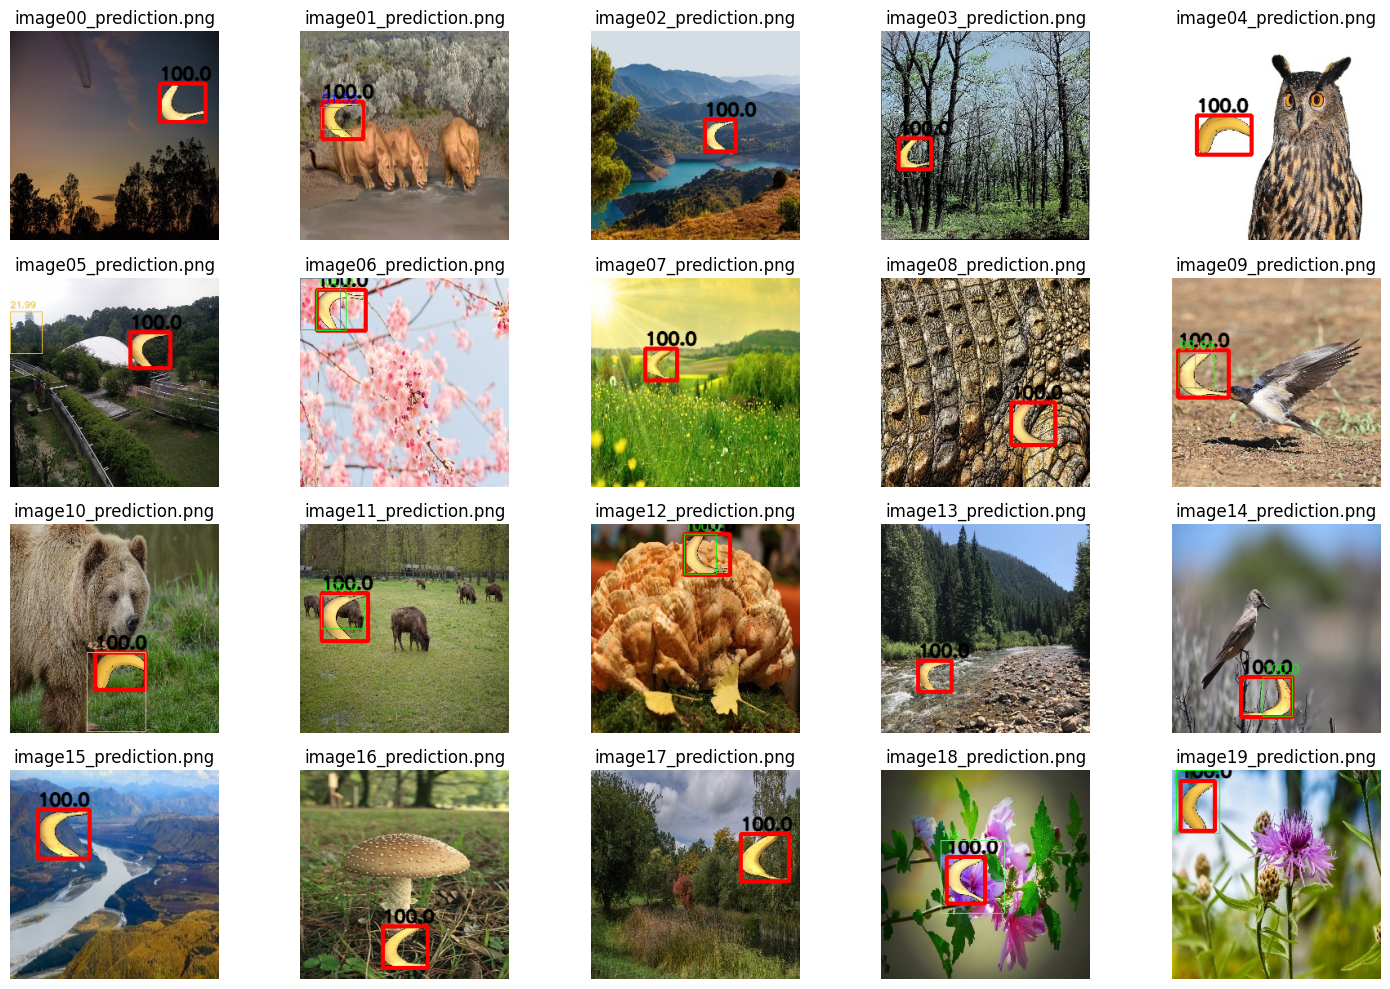

In [203]:
import os
import cv2
import matplotlib.pyplot as plt

def plot_images_from_folder(folder_path, num_images=20):
    """
    Plot images from a specified folder in a grid.

    Parameters:
        folder_path (str): Path to the folder containing images.
        num_images (int): Number of images to display (default is 20).
    """
    # Get a list of image files in the specified folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Limit the number of images to the specified number
    image_files = image_files[:num_images]

    # Set up the plot
    columns = 5
    rows = (len(image_files) + columns - 1) // columns  # Calculate the number of rows needed
    fig, axes = plt.subplots(rows, columns, figsize=(15, 10))

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i, image_file in enumerate(image_files):
        # Load the image using OpenCV
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)

        # Convert the image from BGR to RGB (OpenCV loads images in BGR format)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image in the corresponding subplot
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis labels
        axes[i].set_title(image_file)  # Show the image file name as the title

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_from_folder('output', num_images=20)

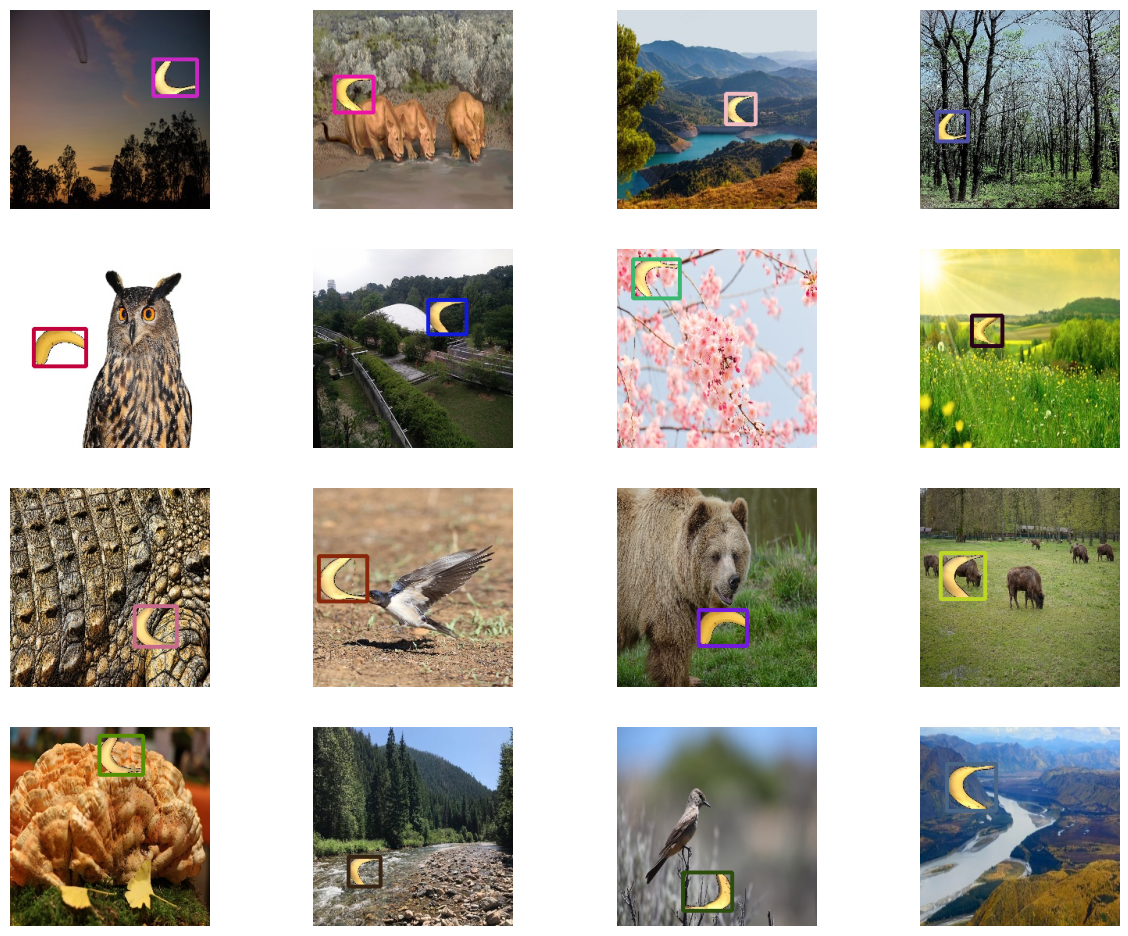

In [204]:
# Visualizando alguns exemplos do dataset por meio do Generator criado
plt.figure(figsize=(15,15))
for i in range(16):
    #gera subfigures
    plt.subplot(5, 4, i + 1)
    im = cv2.imread(p_test[i][0])
    xmin, ymin = p_test[i][1][0], p_test[i][1][1]  # Coordenadas superiores esquerdas do retângulo
    xmax, ymax = p_test[i][1][2], p_test[i][1][3]  # Coordenadas inferiores direitas do retângulo

    posicao = (xmin, ymin)
    fonte = cv2.FONT_HERSHEY_SIMPLEX
    tamanho_fonte = 0.35
    espessura = 0
    color = [np.random.randint(0, 255) for j in range(0, 3)]
    #cv2.putText(im, str(round(probsList[i]*100,2)), posicao, fonte, tamanho_fonte, color, espessura, cv2.LINE_AA)
    cv2.rectangle(im, (xmin, ymin), (xmax, ymax), color, 3)
    image_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis labels
    #plt.set_title(f'image{i}_output.png')  # Show the image file name as the title
plt.show()

# Plotando ROIs selecionados pelo segmentador

In [205]:
def save_rois(loaded_data):
    for i, xroi in enumerate(loaded_data):
        im = cv2.imread(xroi[0])
        for (x, y, w, h) in xroi[2]:  # Usar actual_rects
            color = [np.random.randint(0, 255) for j in range(3)]
            cv2.rectangle(im, (x, y), (x + w, y + h), color, 1)
        pasta = Path('output-roi')
        # Criar a pasta se ela não existir
        pasta.mkdir(parents=True, exist_ok=True)
        formatted_index = str(i).zfill(2)  # Formatando o índice
        image_filename = f"image{formatted_index}_ROIs.png"  # Usar a extensão desejada
        result_file = os.path.join(pasta, image_filename)
        cv2.imwrite(result_file, im)

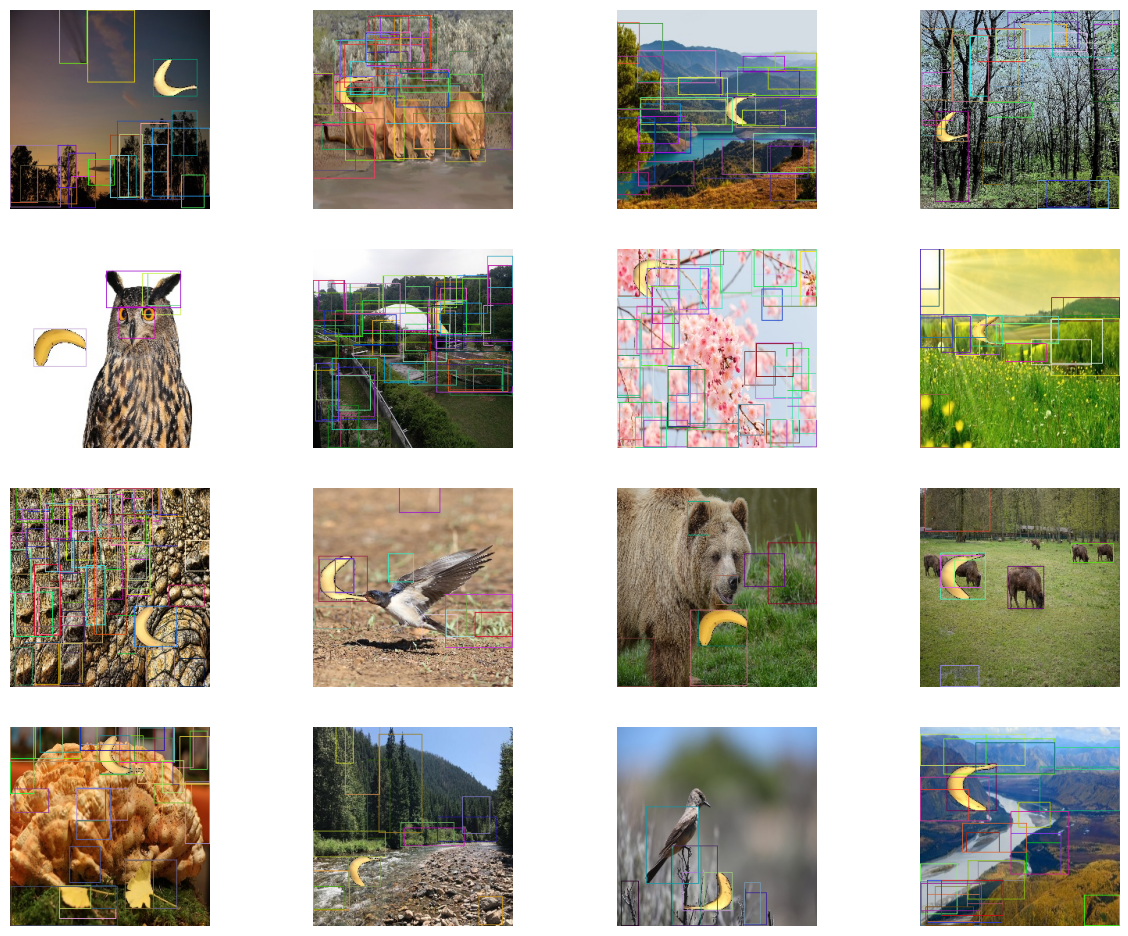

In [206]:
# Carregar dados do arquivo zip
zip_filename = 'roi_data21_25_full.zip'
loaded_data = load_data_from_zip(zip_filename)

# Salva os ROIs a partir dos dados carregados
save_rois(loaded_data)

# Plotar os ROIs a partir dos arquivos salvos
plt.figure(figsize=(15, 15))
output_dir = 'output-roi'  # Diretório dos arquivos salvos
roi_files = sorted(os.listdir(output_dir))  # Listar os arquivos na ordem

for i in range(min(16, len(roi_files))):  # Limitar para 16 imagens
    plt.subplot(5, 4, i + 1)
    im = cv2.imread(os.path.join(output_dir, roi_files[i]))  # Lê a imagem do arquivo
    image_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # Converte para RGB
    # Exibe a imagem
    plt.imshow(image_rgb)
    plt.axis('off')  # Desliga os eixos
plt.show()

# IoU Médio e Mínimo

IoU média: 0.9377117447082414
IoU mínima: 0.8735689397710303
Posição da IoU mínima: 70


C:\Users\guilh.DESKTOP-SI1KHG2\AppData\Local\Temp\ipykernel_3796\4094335061.py:44: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  markerline, stemlines, baseline = plt.stem(indices, ious, basefmt=" ", label='IoUs', use_line_collection=True)


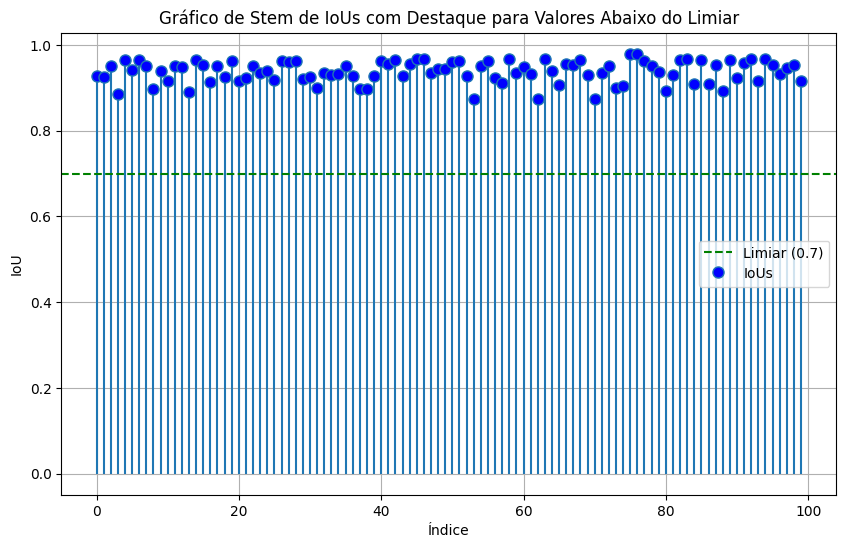

In [207]:
import numpy as np
import matplotlib.pyplot as plt



def calculate_mean_and_min_iou(y_test, y_pred):
    """
    Calcula a IoU média e mínima entre duas listas de caixas delimitadoras.

    Args:
        y_test: Lista de caixas reais (ground truth) no formato [x1, y1, x2, y2].
        y_pred: Lista de caixas previstas no formato [x1, y1, x2, y2].

    Returns:
        mean_iou: A IoU média entre as caixas.
        min_iou: A menor IoU entre as caixas.
        min_iou_index: A posição (índice) da menor IoU.
        ious: Lista de todas as IoUs calculadas.
    """
    ious = []
    for i in range(len(y_pred)):
        iou = calculate_iou(y_test[i], y_pred[i])
        ious.append(iou)

    # Calcula a média e o mínimo das IoUs
    mean_iou = np.mean(ious) if len(ious) > 0 else 0
    min_iou = np.min(ious) if len(ious) > 0 else 0
    min_iou_index = int(np.argmin(ious)) if len(ious) > 0 else -1

    return mean_iou, min_iou, min_iou_index, ious

def plot_stem_ious_with_annotations(ious, threshold=0.8):
    """
    Plota um gráfico de stem das IoUs e anota os índices menores que o limiar ao lado das bolinhas vermelhas.

    Args:
        ious: Lista de IoUs.
        threshold: Limiar para detectar IoUs baixas (default = 0.7).
    """
    indices = range(len(ious))

    # Plotar o gráfico de stem com todas as IoUs
    plt.figure(figsize=(10, 6))
    markerline, stemlines, baseline = plt.stem(indices, ious, basefmt=" ", label='IoUs', use_line_collection=True)
    plt.setp(markerline, 'markerfacecolor', 'b', 'markersize', 8)  # Definir as bolinhas azuis para IoUs

    # Plotar a linha do limiar
    plt.axhline(y=threshold, color='g', linestyle='--', label=f'Limiar ({threshold})')

    # Encontrar índices onde a IoU é menor que o threshold
    low_iou_indices = [i for i, iou in enumerate(ious) if iou < threshold]

    # Anotar e destacar as IoUs menores que o limiar
    for idx in low_iou_indices:
        plt.plot(idx, ious[idx], 'ro')  # Bolinha vermelha para IoUs menores que o threshold
        plt.text(idx, ious[idx], f'{idx}', color='red', fontsize=12, ha='left', va='bottom')  # Adicionar índice

    # Configurações do gráfico
    plt.xlabel('Índice')
    plt.ylabel('IoU')
    plt.title('Gráfico de Stem de IoUs com Destaque para Valores Abaixo do Limiar')
    plt.legend()
    plt.grid(True)
    plt.show()

# Cálculo Médio e Mínimo IoU
mean_iou, min_iou, min_iou_index, ious = calculate_mean_and_min_iou(y_test, y_pred)

print("IoU média:", mean_iou)
print("IoU mínima:", min_iou)
print("Posição da IoU mínima:", min_iou_index)

# Plotar o gráfico de stem com anotações para IoUs menores que 0.7
plot_stem_ious_with_annotations(ious, threshold=0.7)
